# 4a) Akustik Parametreler, Düşük Seviyeli Öznitelikler

<a href="https://colab.research.google.com/drive/1ygRlbLbyu_lBYQRvuGIdgqrMzi3iOR9J?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




## Akustik parametreler, Düşük Seviyeli Öznitelikler
Birçok ses işleme uygulaması, ses sinyalinden akustik parametrelerin hesaplanması ve bu parametrelerden yola çıkarak etiketleme, sınıflandırma, manipülasyon, vb. işlemlerin gerçekleştirilmesine dayanır. Bu defterimizde, teknik terminolojide "düşük seviyeli öznitelikler" (İng: low level features) olarak adlandırılan akustik parametrelerden sık kullanılan birkaçının hesaplanmasını ele alacağız. Buradaki örnekleri anlamak size literatürde tanımlanmış diğer parametrelerin hesaplanması için fonksiyonlar yazma konusunda yeterli altyapıyı büyük oranda sunacaktır.

Şu parametrelerin hesaplanmasını ele alacağız:

*   Enerji
*   Sıfır kesim oranı
*   Spektral merkez
*   Temel titreşim frekansı

Bu parametrelerin düşük seviyeli olarak sınıflandırılmasının nedeni ses işleme adımlarının en başında doğrudan ses sinyalinden hesaplanıyor olmalarıdır. Sürecin en alt seviyeden en yükseğe doğru organize olduğu, en yüksek seviyede etiket veya sınıf gibi sinyale dair "üst seviyede" kararlar alındığını düşünebilirsiniz. 

Ses işleme tasarım sürecini daha net ortaya koymak için kendimize bir hedef koyalım: verilen bir kaydın öpücük sesi mi ıslık sesi mi olduğuna otomatik karar veren bir sistem tasarlamak istediğimizi düşünelim. Böyle sistem tasarlamak istediğimizde öncelikle kendimize şu soruyu sorarız: bu iki kategoriyi birbirinden ayırmamızı sağlayacak özellikler/öznitelikler/akustik-parametreler (İng: discriminative features) nelerdir? Islık sesinin tiz bir melodi içereceğini, periyodik olacağını; öpücük sesinin ise bir melodi içermeyeceğini, daha çok kısa süreli gürültüye benzer özellikleri olacağını öngörebiliriz. Bu durumda, temel titreşim periyodunu/frekansını hesaplamak faydalı olacaktır. Yine periyodik ve periyodik olmayan sinyalleri birbirinden ayırmada faydalı olan sıfır kesim oranı ve spektral merkez parametrelerini hesaplamak (bunları aşağıda tanımlıyoruz) da faydalı olacaktır. Ayrıca sinyallerimizde sessiz kısımlar olacağını varsayabiliriz. Bu kısımlar analize dahil edilmemeli, sonucu etkilememeliler. Bunun için de sinyalin küçük kesitlerinin enerjisini hesaplayıp enerjisi düşük olan kısımları dışarıda bırakabiliriz. 

Bu parametre hesaplamalarının tümünü sinyalin küçük kesitleri üzerinde yürütmeyi tercih edeceğiz. Çünkü sinyal özelliği sürekli değişiyor. Bunun sonucu olarak parametreler sürekli değişiyor. Tekil sinyal örneklerinden bu parametreleri ölçmek mümkün olmayacağı için (örneğin tek nokta ile frekans ölçmek mümkün değildir, sinyalin en az bir kere kendisini tekrar ettiği bir kesitinin alınması gerekir) parametre kestirim işlemimizin ön adımı sinyali küçük kesitlerine ayırmak (pencerelemek) olacaktır. Daha önceki defterlerde ele aldığımız gibi; sinyalin spektrumu, pencereleme işleminden etkilenmektedir ve kesiti aldıktan sonra bir pencere fonksiyonu ile çarpmak bazı spektral özelliklerin daha güvenilir bir şekilde hesaplanmasını sağlamaktadır. Parametre ölçen/hesaplayan/kestiren fonksiyonlarımız pencereleme işlemini içerecek.

| <img src="https://www.researchgate.net/publication/346243843/figure/fig1/AS:961807523000322@1606324191138/Short-time-Fourier-transform-STFT-overview.png" width=350/> |
| :-----------------------------------------------------------------------------------------------------------------------------------------------------------: |
|                                                   Şekil 6.1: _Analizi yapılacak sinyale uygulanan pencereleme işlemi_                                                   |

Öncelikle kütüphanelerimizi yükleyelim, bir dizi ıslık ve öpücük sesi indirelim. 

In [ ]:
import os
import sys
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import soundfile as sf
import urllib.request
import librosa
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

Verilerimizin kaynağı [FreeSound](https://freesound.org/) sitesi olup paket halinde [şu adresten](https://github.com/MTG/MIRCourse/tree/master/data/freesound) indireceğiz. 



In [ ]:
opucuk_sesleri_linkleri = ['https://github.com/MTG/MIRCourse/raw/master/data/freesound/kiss_'+str(i)+'.wav' for i in range(10) if i!=2]
islik_sesleri_linkleri = ['https://github.com/MTG/MIRCourse/raw/master/data/freesound/whistle_'+str(i)+'.wav' for i in [0,1,2,6,8,9]]
ses_linkleri = opucuk_sesleri_linkleri + islik_sesleri_linkleri

dosya_isimleri = []
for dosya_linki in ses_linkleri:
  dosya_ismi = dosya_linki.split('/')[-1]
  urllib.request.urlretrieve(dosya_linki, dosya_ismi)
  dosya_isimleri.append(dosya_ismi)
print('İndirilen dosyalar:', dosya_isimleri)

İndirilen dosyalar: ['kiss_0.wav', 'kiss_1.wav', 'kiss_3.wav', 'kiss_4.wav', 'kiss_5.wav', 'kiss_6.wav', 'kiss_7.wav', 'kiss_8.wav', 'kiss_9.wav', 'whistle_0.wav', 'whistle_1.wav', 'whistle_2.wav', 'whistle_6.wav', 'whistle_8.wav', 'whistle_9.wav']


In [ ]:
# Öpücük sesi örneği dinleyelim
ses_sinyali_1, ornekleme_fr = sf.read('kiss_3.wav')
print('Örnek dosya:', 'kiss_3.wav', 'Ornekleme frekansı: ', ornekleme_fr, 'Hz')
Audio(ses_sinyali_1, rate=ornekleme_fr)

Örnek dosya: kiss_3.wav Ornekleme frekansı:  44100 Hz


In [ ]:
# Islık sesi örneği dinleyelim
ses_sinyali_2, ornekleme_fr = sf.read('whistle_2.wav')
print('Örnek dosya:', 'whistle_2.wav', 'Ornekleme frekansı: ', ornekleme_fr, 'Hz')
Audio(ses_sinyali_2, rate=ornekleme_fr)

Örnek dosya: whistle_2.wav Ornekleme frekansı:  44100 Hz


İlk iş olarak bu örnek ses sinyallerini pencereleyip her bir pencere için enerji hesaplayalım ve enerji değişimini sinyalle beraber çizdirelim. Bu, gerçekleştirdiğimiz ilk parametre hesaplama işlemi olacak. Daha sonra diğer parametreleri ele alacağız.


Sayısal bir sinyalin enerjisi örneklerinin karelerinin toplamı şeklinde tanımlanabilir ([bakınız](https://en.wikipedia.org/wiki/Energy_(signal_processing))):

$$
enerji = \sum_{n = 0}^{N-1} |x[n]|^2
$$

Her sinyal penceresi/kesiti için bir enerji değeri hesaplayan ve bu değerleri içeren bir dizi oluşturup döndüren bir fonksiyon yazalım. Fonksiyonumuz sinyal ile beraber, kullanılacak pencere fonksiyonunun adını, pencerelerin genişliği ve ardışık pencereler arasındaki uzaklığı (ardışık pencerelerin başlangıç noktaları arasındaki farkı, veya pencere kaydırma miktarını) alacak. 

In [ ]:
def enerji_hesapla(x_n):
  return np.sum(np.power(x_n, 2)) # yukarıda verilen formülü uygulayan satır

def parametre_hesapla(x, parametre_adi, pencere_fonksiyon_adi, pencere_genisligi, pencere_kaydirma_miktari):
  '''Pencereleme işlemini gerçekleştirip her kesit/pencere için parametre hesaplama fonksiyonunu çağırır ve
  sonuçları bir dizide toplayarak döndürür'''
  # Sinyal kesitlerini çarpacağımız pencere fonksiyonunu oluşturalım
  pencere_fonksiyonu = signal.get_window(pencere_fonksiyon_adi, pencere_genisligi)

  # Pencerelerin baslangic noktalarını hesaplayalım. Pencereler ilk örnekten başlamalı ve
  #  son pencere dışarı taşmamalı
  pencere_baslangiclari = np.arange(0, x.size - pencere_genisligi, pencere_kaydirma_miktari, dtype = int)
  pencere_sayisi = pencere_baslangiclari.size
  pencere_orta_noktalari = pencere_baslangiclari + int(pencere_genisligi/2)

  parametre = np.zeros((pencere_sayisi,))
  for k in range(pencere_sayisi):
      pencere_baslangici = pencere_baslangiclari[k]
      # Kesit sinyalin oluşturulması
      x_win = x[pencere_baslangici:pencere_baslangici + pencere_genisligi] * pencere_fonksiyonu
      # Kesit sinyal için parametre hesabı
      if parametre_adi == 'enerji':
        parametre[k] = enerji_hesapla(x_win)
      elif parametre_adi == 'sifir_kesim_orani':
        parametre[k] = sifir_kesim_orani_hesapla(x_win)
      elif parametre_adi == 'spektral_merkez':
        parametre[k] = spektral_merkez_hesapla(x_win)
  return parametre, pencere_orta_noktalari

Yazdığımız fonksiyonu kullanarak iki sinyal için enerji hesaplayalım ve sinyal dalga formu ile beraber çizdirelim. Burada dikkat etmemiz gereken nokta, enerji dizisindeki örnek sayısının çok daha az (her bir kesit için bir enerji değeri) oluşu. Enerji sinyalinin örnekleme frekansını ele alalım; her pencere için bir değerimiz var, ardışık değerler arasında pencere kaydırma miktarı kadar fark var. Bu durumda enerji sinyalimizin örnekleme periyodu pencere kaydırma miktarı kadardır. Hz cinsinden örnekleme frekansını bulmak isterseniz bu değeri saniye cinsinden hesaplayıp tersini hesaplayabilirsiniz.  

Sinyalin dalga formunu hesaplanan parametre dizisiyle beraber senkron çizdirmek için bir fonksiyon yazalım.

In [ ]:
def sinyal_ve_parametre_cizdir(x_n, parametre_dizi_listesi, pencere_orta_noktalari, parametre_isim_listesi):
  # Normalizasyon: çizimlerin benzer büyüklüğe sahip olması için uygulanıyor
  x_n = x_n / np.max(np.abs(x_n))
  fig = plt.figure(figsize=(12, 4))
  plt.plot(x_n, 'b', label = 'Ses signali'+' (normalize)')

  for parametre_dizisi, parametre_ismi, renk in zip(parametre_dizi_listesi, parametre_isim_listesi, 'rcmykg'):
    parametre_dizisi = parametre_dizisi / np.max(np.abs(parametre_dizisi[~np.isnan(parametre_dizisi)])) 
    # Senkronizasyonu sağlamak için parametre dizisini pencere orta noktalarına(endeks cinsinden) göre çizelim
    plt.plot(pencere_orta_noktalari, parametre_dizisi, renk, label = parametre_ismi+' (normalize)')
  plt.ylabel('Normalize genlik');plt.xlabel('Zaman (endeks)');
  plt.axis('tight')
  plt.legend()
  plt.show()

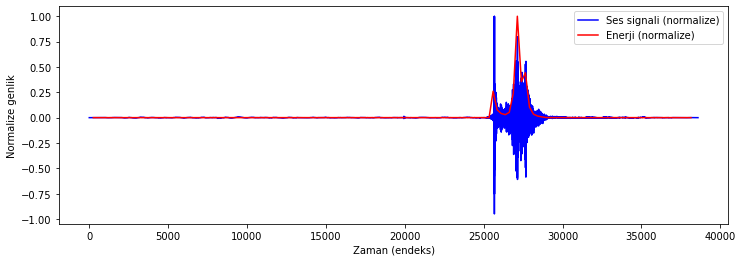

In [ ]:
# İlk sinyal için enerji sinyalini dalga formuyla beraber çizdirme
pencere_genisligi = 512; pencere_kaydirma_miktari = 256 # değerler örnek sayısı cinsinden
enerji_1, pencere_orta_noktalari_1 = parametre_hesapla(ses_sinyali_1, 'enerji', 'hanning', pencere_genisligi, pencere_kaydirma_miktari)
sinyal_ve_parametre_cizdir(ses_sinyali_1, [enerji_1], pencere_orta_noktalari_1, ['Enerji'])

Şekil 6.2: Öpücük sesi örneği dalga formu ve enerji

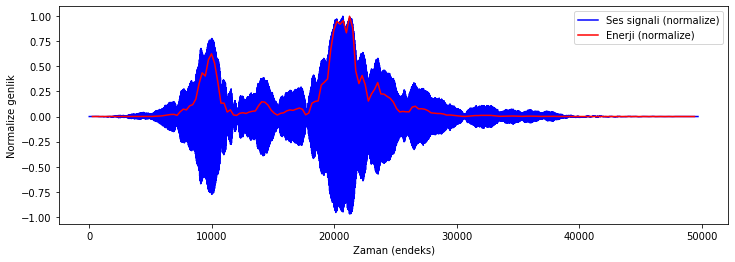

In [ ]:
# İkinci sinyal için enerji sinyalini dalga formuyla beraber çizdirme
enerji_2, pencere_orta_noktalari_2 = parametre_hesapla(ses_sinyali_2, 'enerji', 'hanning', pencere_genisligi, pencere_kaydirma_miktari)
sinyal_ve_parametre_cizdir(ses_sinyali_2, [enerji_2], pencere_orta_noktalari_2, ['Enerji'])

Şekil 6.3: Islık sesi örneği dalga formu ve enerji

Hesaplanan enerji değerleri ile sinyal dalga formu arasında yakın bir ilişki olduğunu görebiliyoruz. Şimdi diğer parametrelerin tanımlarına bakalım: 

Sıfır kesim oranı bir sinyal kesiti içerisinde örneklerin kaç kere işaret değiştirdiğinin sayısıdır. Toplam örnek sayısına bölünerek orana dönüştürülür. Gürültü karakteri olan sinyallerde örnekler sıfır çevresinde sürekli değişeceği için sıfır kesim oranının yüksek olması beklenir. Periyodik sinyallerde periyod özellikle çok kısa değilse görece değerinin yüksek olması beklenir.

$$
Sıfır Kesim Oranı = \frac{1}{N-1} \sum_{n=1}^{N-1} | sign(x[n]) - sign(x[n-1]) |
$$
$$
sign(x[n])  = \begin{cases}
  1, & x[n] > 0 \text{ ise } \\ 
  0, & x[n] = 0 \text{ ise } \\ 
  -1,& x[n] < 0 \text{ ise } 
\end{cases}
$$


Spektral merkez, genlik spektrumunu örnekleri ($X[k]$) ağırlık değerleri olarak düşünüldüğünde ağırlık merkezine (bu değer endeks türündedir) karşılık gelir. [Kütle ağırlık merkezi](https://en.wikipedia.org/wiki/Centroid)ne benzer şekilde tanımlanır.

$$
Spektral Merkez = \frac{\sum_{k=0}^{N-1} k|X[k]|}{\sum_{k=0}^{N-1} |X[k]|}
$$


Bu tanımları gerçekleyen fonksiyonlarımızı yazalım.

In [ ]:
def sifir_kesim_orani_hesapla(x_n):
  signX = np.sign(x_n)
  fark_signX_signXn_1 = signX[1:]-signX[:-1]
  return np.sum(np.abs(fark_signX_signXn_1))/ (x_n.size - 1)

def spektral_merkez_hesapla(x_n, fft_N = 256):
  X_w = np.fft.fft(x_n, fft_N)
  genlik_spek = np.abs(X_w[:int(fft_N / 2)])
  return (np.dot(genlik_spek, np.arange(genlik_spek.size)) / np.sum(genlik_spek)) / fft_N


Sinyallerimiz için bu parametreleri hesaplayalım:

In [ ]:
sifir_kesim_orani_1, pencere_orta_noktalari_1 = parametre_hesapla(ses_sinyali_1, 'sifir_kesim_orani', 'hanning', pencere_genisligi, pencere_kaydirma_miktari)
sifir_kesim_orani_2, pencere_orta_noktalari_2 = parametre_hesapla(ses_sinyali_2, 'sifir_kesim_orani', 'hanning', pencere_genisligi, pencere_kaydirma_miktari)

spektral_merkez_1, pencere_orta_noktalari_1 = parametre_hesapla(ses_sinyali_1, 'spektral_merkez', 'hanning', pencere_genisligi, pencere_kaydirma_miktari)
spektral_merkez_2, pencere_orta_noktalari_2 = parametre_hesapla(ses_sinyali_2, 'spektral_merkez', 'hanning', pencere_genisligi, pencere_kaydirma_miktari)

Diğer bir akustik parametre olarak temel titreşim frekansını hesaplayacağımızı söylemiştik. Frekans, saniyede tekrar sayısına karşılık gelmekte olup ilerideki defterlerimizde hesaplanma yöntemleri daha detaylı ele alınacaktır. Bu defterimizde bu parametre için hazır fonksiyon kullanacağız: [librosa.pyin](https://librosa.org/doc/main/generated/librosa.pyin.html)

In [ ]:
f0_1, voiced_flag_1, periyodiklik_1 = librosa.pyin(ses_sinyali_1, fmin=50, fmax=3000, sr=ornekleme_fr, win_length=pencere_genisligi, hop_length=pencere_kaydirma_miktari)
f0_2, voiced_flag_2, periyodiklik_2 = librosa.pyin(ses_sinyali_2, fmin=50, fmax=3000, sr=ornekleme_fr, win_length=pencere_genisligi, hop_length=pencere_kaydirma_miktari)

Librosa.pyin frekans değerleriyle beraber her bir penceredeki sinyalin periyodik olma olasılığını da döndürüyor (adına kısaca periyodiklik dedik, detaylar için dokümantasyonu inceleyiniz). Onu da bir parametre olarak düşünüp kullanabiliriz. Librosa.pyin kendi pencereleme işlemini gerçekleştirdi. Elde edilen parametre dizisi aynı uzunlukta olmayabilir. Kontrol edelim:

In [ ]:
print('İlk sinyal parametre dizi uzunlukları: enerji, sıfır kesim oranı, spektral merkez:', enerji_1.shape, sifir_kesim_orani_1.shape, spektral_merkez_1.shape)
print('İlk sinyal parametre dizi uzunlukları: f0, periyodik olma olasılığı:', f0_1.shape, periyodiklik_1.shape)
print('İkinci sinyal parametre dizi uzunlukları: enerji, sıfır kesim oranı, spektral merkez:', enerji_2.shape, sifir_kesim_orani_2.shape, spektral_merkez_2.shape)
print('İkinci sinyal parametre dizi uzunlukları: f0, periyodik olma olasılığı:', f0_2.shape, periyodiklik_2.shape)

İlk sinyal parametre dizi uzunlukları: enerji, sıfır kesim oranı, spektral merkez: (149,) (149,) (149,)
İlk sinyal parametre dizi uzunlukları: f0, periyodik olma olasılığı: (151,) (151,)
İkinci sinyal parametre dizi uzunlukları: enerji, sıfır kesim oranı, spektral merkez: (193,) (193,) (193,)
İkinci sinyal parametre dizi uzunlukları: f0, periyodik olma olasılığı: (195,) (195,)


Librosa.pyin her iki sinyal için de iki nokta fazla döndürdü. Bu dizilerden baştan ve sondan birer nokta dışarıda bırakalım.

In [ ]:
f0_1 = f0_1[1:-1];periyodiklik_1 = periyodiklik_1[1:-1]
f0_2 = f0_2[1:-1];periyodiklik_2 = periyodiklik_2[1:-1]

Şimdi tüm parametre dizilerini sinyal dalga formumuzla beraber çizdirebiliriz

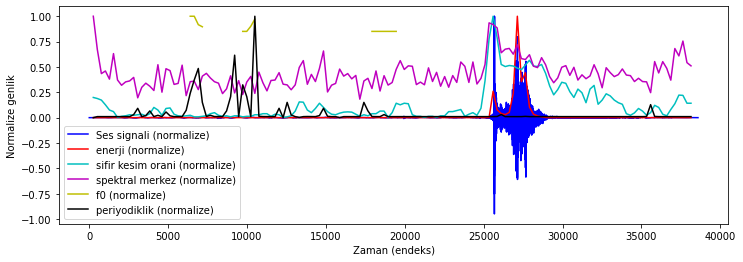

In [ ]:
sinyal_ve_parametre_cizdir(ses_sinyali_1, [enerji_1, sifir_kesim_orani_1, spektral_merkez_1, f0_1, periyodiklik_1], pencere_orta_noktalari_1, ['enerji','sifir kesim orani','spektral merkez','f0', 'periyodiklik'])

Şekil 6.4: Öpücük sesi örneği dalga formu ve düşük seviyeli parametreler

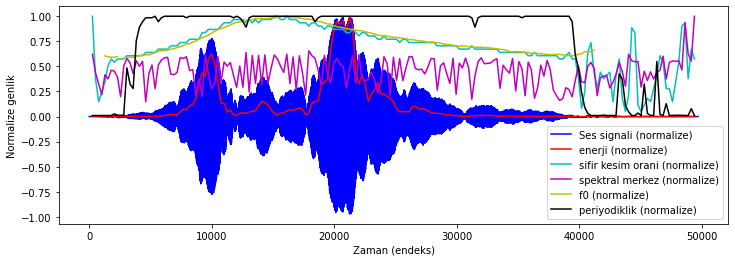

In [ ]:
sinyal_ve_parametre_cizdir(ses_sinyali_2, [enerji_2, sifir_kesim_orani_2, spektral_merkez_2, f0_2, periyodiklik_2], pencere_orta_noktalari_2, ['enerji','sifir kesim orani','spektral merkez','f0', 'periyodiklik'])

Şekil 6.5: Islık sesi örneği dalga formu ve düşük seviyeli parametreler

Şekilleri incelediğimizde kayıtlardaki sessiz bölgeler için hesaplanmış parametre değerlerinin oldukça gürültülü olduğunu görebiliyoruz. Bir kayda dair işlem yaparken bu kısımların dışarıda bırakılmasında fayda var. Bunun için enerji parametresini kullanabiliriz. Enerjinin, o sinyaldeki maksimum enerjinin %2si altına düşen bölgelerinin sessiz olduğunu varsayıp bu bölgelerdeki parametre değerlerini dışarıda bırakalım.

In [ ]:
oran = 0.02
esik_deger_1 = np.max(enerji_1) * oran
sifir_kesim_orani_1 = sifir_kesim_orani_1[enerji_1 > esik_deger_1]
spektral_merkez_1 = spektral_merkez_1[enerji_1 > esik_deger_1]
f0_1 = f0_1[enerji_1 > esik_deger_1]

esik_deger_2 = np.max(enerji_2) * oran
sifir_kesim_orani_2 = sifir_kesim_orani_2[enerji_2 > esik_deger_2]
spektral_merkez_2 = spektral_merkez_2[enerji_2 > esik_deger_2]
f0_2 = f0_2[enerji_2 > esik_deger_2]


Kayıtları sınıflandırmak istediğimizde, tekil pencereleri karşılaştırmak yerine kaydın tümünde bir parametrenin aldığı değerler bizim için önemli olacaktır. Her bir örnek için parametrelerin dağılımlarını inceleyelim. 

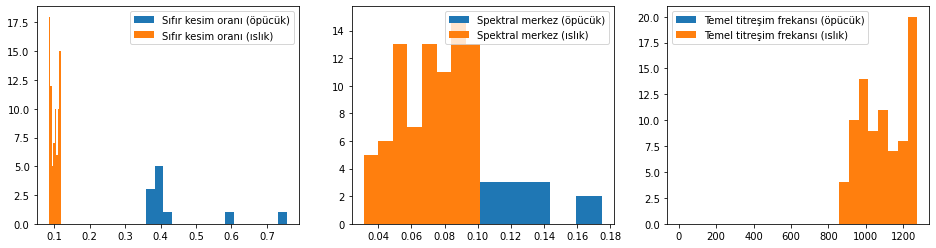

In [ ]:
plt.figure(figsize=(16,4))
plt.title('Parametre histogramları')
plt.subplot(1,3,1);
plt.hist(sifir_kesim_orani_1, bins='auto', label='Sıfır kesim oranı (öpücük)'); 
plt.hist(sifir_kesim_orani_2, bins='auto', label='Sıfır kesim oranı (ıslık)');
plt.legend();
plt.subplot(1,3,2);
plt.hist(spektral_merkez_1, bins='auto', label='Spektral merkez (öpücük)'); 
plt.hist(spektral_merkez_2, bins='auto', label='Spektral merkez (ıslık)');
plt.legend();
plt.subplot(1,3,3);
# Nan değerlerle histogram çizdiremeyeceğimiz için Nan'ları 0 ile eşleyelim
f0_1[np.isnan(f0_1)] = 0;f0_2[np.isnan(f0_2)] = 0;
plt.hist(f0_1, bins='auto', label='Temel titreşim frekansı (öpücük)'); 
plt.hist(f0_2, bins='auto', label='Temel titreşim frekansı (ıslık)');
plt.legend();

Şekil 6.6: İki ses kaydından (öpücük ve ıslık) hesaplanan düşük seviyeli parametrelerin histogramları

Şekilleri incelediğimizde bu kayıtların parametrelerinin dağılımlarının birbirinden ayrık olduğunu görebiliyoruz. Hedefimiz otomatik sınıflandırma yapabilmek olduğu için bu iyi bir haber. Parametrelerin tekil değerleri yerine istatistiksel değerlerini kullanarak ayırma işlemi gerçekleştirmeyi düşünebiliriz. 

Bu gerçekten de otomatik ses sınıflandırmada çok sık kullanılan bir yöntem. Parametrelerin tekil değerlerine lokal değerler/öznitelikler (İng: local features), ortalama ve standart sapma gibi istatistiksel değerlerine de global değerler/öznitelikler (İng: global features) ismi verilir.

Şimdi indirdiğimiz her kayıt için parametrelerimizin global öznitelik değerlerini karşılaştıralım. 

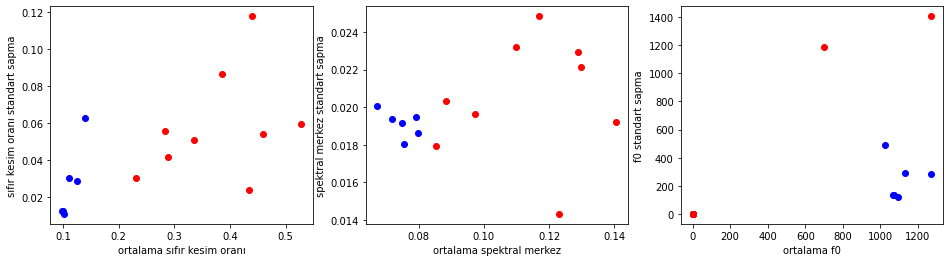

In [ ]:
enerji_esik_orani = 0.02
pencere_genisligi = 512; pencere_kaydirma_miktari = 256
plt.figure(figsize=(16,4))
for dosya in dosya_isimleri:
  sinif = dosya.split('_')[0] # sınıf bilgisi dosyanın baş kısmında veriliyor
  # Çizimlerde sınıfa göre renk seçimi yapalım
  if sinif == 'kiss':
    renk = 'r'
  else:
    renk = 'b'
  # ses dosyasının okunup genlik normalizasyonuna tabi tutulması
  ses_sinyali, ornekleme_fr = sf.read(dosya)
  ses_sinyali /= np.max(np.abs(ses_sinyali))
  
  # Parametrelerin hesaplanması
  enerji, pencere_orta_noktalari = parametre_hesapla(ses_sinyali, 'enerji', 'hanning', pencere_genisligi, pencere_kaydirma_miktari)
  sifir_kesim_orani, pencere_orta_noktalari = parametre_hesapla(ses_sinyali, 'sifir_kesim_orani', 'hanning', pencere_genisligi, pencere_kaydirma_miktari)
  spektral_merkez, pencere_orta_noktalari = parametre_hesapla(ses_sinyali, 'spektral_merkez', 'hanning', pencere_genisligi, pencere_kaydirma_miktari)
  f0, v, p = librosa.pyin(ses_sinyali, fmin=50, fmax=3000, sr=ornekleme_fr, win_length=pencere_genisligi, hop_length=pencere_kaydirma_miktari)
  f0 = f0[1:-1] # librosa.pyin kenarlardan birer pencere fazla alıyor, diğerleri ile eşlemek için dışarıda bırakalım
  
  # Enerjisi düşük bölgelerdeki parametrelerin dışarıda bırakılması
  esik_deger = np.max(enerji) * enerji_esik_orani
  sifir_kesim_orani = sifir_kesim_orani[enerji > esik_deger]
  spektral_merkez = spektral_merkez[enerji > esik_deger]
  f0 = f0[enerji > esik_deger]
  # Nan değerlerin sıfıra eşlenmesi
  f0[np.isnan(f0)] = 0

  # Her bir kayıt için figürlere birer nokta koyalım
  plt.subplot(1,3,1)
  plt.plot(np.mean(sifir_kesim_orani), np.std(sifir_kesim_orani), renk+'o')
  plt.subplot(1,3,2)
  plt.plot(np.mean(spektral_merkez), np.std(spektral_merkez), renk+'o')
  plt.subplot(1,3,3)
  plt.plot(np.mean(f0), np.std(f0), renk+'o')
  
plt.subplot(1,3,1);plt.xlabel('ortalama sıfır kesim oranı');plt.ylabel('sıfır kesim oranı standart sapma');
plt.subplot(1,3,2);plt.xlabel('ortalama spektral merkez');plt.ylabel('spektral merkez standart sapma');
plt.subplot(1,3,3);plt.xlabel('ortalama f0');plt.ylabel('f0 standart sapma');


Şekil 6.7: Kayıtlarından hesaplanan düşük seviyeli parametrelerin ortalama ve standart sapma değerleri (her öpücük kaydı bir kırmızı nokta ile ve her ıslık kaydı bir mavi nokta ile temsil edilmiştir)

Şekil 6.7'yi incelediğimizde global/istatistiksel değerler uzayında ıslık ve öpücük örneklerinin ayrı bölgelere düştüğünü görebiliyoruz. Bu gözlemden yola çıkarak bu parametreleri kullanarak otomatik sınıflandırma işlemini başarıyla gerçekleştiren bir sistem tasarlayabileceğimizi öngörebiliriz. Örneğin ortalama sıfır kesim oranı değeri 0.2'nin altında olan örnekleri ıslık, üstünde olan örnekleri öpücük olarak sınıflandırmayı düşünebiliriz.

Yukarıda parametre hesaplamalarını kendi fonksiyonlarımızı yazarak gerçekleştirdik. Ses işleme kütüphaneleri parametre hesaplama için bize hazır fonksiyonlar sunar. Essentia kütüphanesi ile aynı parametrelerin hesaplanmasına dair bir örnek için [bakınız](https://github.com/MTG/MIRCourse/blob/master/notebooks/Lecture1_step2_usingEssentiaStandard.ipynb). 

Herhangi bir otomatik sınıflandırma problemiyle karşı karşıya olduğumuzda örneklerin gruplaştığı ve bu sayede ayırılabileceği parametreleri/öznitelikleri tespit ettikten sonra standart makine öğrenmesi yöntemleriyle sınıflandırıcılar tasarlayabiliriz. Bir sonraki defterimizde bunu ele alıyoruz.

**Benzer içerikte diğer kaynaklar:** 


*   https://github.com/stevetjoa/stanford-mir/blob/gh-pages/basic_feature_extraction.ipynb
*   https://github.com/stevetjoa/stanford-mir/blob/gh-pages/spectral_features.ipynb


**Yazar:** Barış Bozkurt, **editör:** Ahmet Uysal

---